In [1]:
from Meningioma.preprocessing.tools.remove_extra_channels import remove_first_channel
from Meningioma.preprocessing.tools.casting import cast_volume_and_mask
from Meningioma.preprocessing.tools.nrrd_to_nifti import nifti_write_3d
from Meningioma.preprocessing.tools.denoise_susan import denoise_susan
from Meningioma.preprocessing.tools.bias_field_corr_n4 import n4_bias_field_correction, generate_brain_mask_sitk
from Meningioma.preprocessing.tools.skull_stripping.fsl_bet import fsl_bet_brain_extraction

# Disable GPU usage entirely - slower but more reliable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only

import os

import SimpleITK as sitk

import matplotlib.pyplot as plt

PATH = "/home/mariopasc/Python/Datasets/Meningiomas"
ATLAS = "/home/mariopasc/Python/Datasets/Meningiomas/ATLAS/sri24_spm8/templates/T1_brain.nii"
INPUT_PATH = os.path.join(PATH, "Meningioma_Adquisition")
OUTPUT_PATH = os.path.join(PATH, "output")
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
MODALITY = "RM"
PULSES = ["T1", "T2", "SUSC"]
PATIENT = "1"

data = {}
for pulse in PULSES:
    vol_path = os.path.join(INPUT_PATH, MODALITY, pulse, f"P{PATIENT}", f"{pulse}_P{PATIENT}.nrrd")
    seg_path = os.path.join(INPUT_PATH, MODALITY, pulse, f"P{PATIENT}", f"{pulse}_P{PATIENT}_seg.nrrd")
    data[pulse] = {"vol": vol_path, "seg": seg_path}

    print("=====================================")
    print(f"Processing {pulse}")
    print("=====================================")

    # Load and save paths
    vol_path = data[pulse]["vol"]
    seg_path = data[pulse]["seg"]
    
    # Remove first channel
    vol, hdr = remove_first_channel(nrrd_path=vol_path, channel=0, verbose=True)
    seg, hdr_seg = remove_first_channel(nrrd_path=seg_path, channel=0, verbose=True)
    # Cast volume and mask
    vol, seg = cast_volume_and_mask(volume_img=vol, mask_img=seg)

    # n4 bias field correction
    _, mask_brain = generate_brain_mask_sitk(volume_sitk=vol)
    vol = n4_bias_field_correction(volume_sitk=vol, verbose=True)

    # save files
    nifti_write_3d([vol, hdr], os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}"))
    nifti_write_3d([seg, hdr_seg], os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}_seg"))
    # Save
    data[pulse] = {
        "input_paths": {
            "vol": vol_path,
            "seg": seg_path,
        },
        "arrays": {
            "vol": sitk.GetArrayFromImage(vol),
            "seg": sitk.GetArrayFromImage(seg),
        },
        "output_paths": {
            "vol": os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}.nii.gz"),
            "seg": os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}_seg.nii.gz"),
        }
        
    }

Processing T1
Input volume shape: (416, 512, 192)
Input hdr fields:
 - dimensions: 3
 - sizes: [416 512 192]
 - space directions: [[ 0.46754256838748026 -0.01235863904309036  0.03126936658522083]
 [ 0.01877844950535475  0.45759081350102976 -0.09992286892218787]
 [-0.05533471886129857  0.20022161611266281  0.9065039159753452 ]]
 - kinds: ['domain', 'domain', 'domain']
 - space origin: [ -97.39358329164699 -146.91877981590994  -70.622476993478  ]
Input volume shape: (416, 512, 192)
Input hdr fields:
 - dimensions: 3
 - sizes: [416 512 192]
 - space directions: [[ 0.46754256838748026 -0.01235863904309036  0.03126936658522083]
 [ 0.01877844950535475  0.45759081350102976 -0.09992286892218787]
 [-0.05533471886129857  0.20022161611266281  0.9065039159753452 ]]
 - kinds: ['domain', 'domain', 'domain']
 - space origin: [ -97.39358329164699 -146.91877981590994  -70.622476993478  ]
[N4] Starting bias field correction with the following params:
  shrink_factor=4, max_iterations=50, bias_field_fwhm

In [22]:
from Meningioma.preprocessing.tools.registration import SynthMorphRegister

# Initialize the registration module
registrator = SynthMorphRegister(output_dir=os.path.join(OUTPUT_PATH, "registered"))

# Register all modalities to the atlas
data = registrator.register_all_to_atlas(
    data_dict=data,
    atlas_path=ATLAS,
    patient_id=PATIENT
)

# Visualize the results
registrator.visualize_results(
    data_dict=data,
    pulses=PULSES,
    patient_id=PATIENT,
    # Optional custom slice indices
    # slice_indices={'axial': 80, 'sagittal': 95, 'coronal': 90}
)

Loading atlas from /home/mariopasc/Python/Datasets/Meningiomas/ATLAS/sri24_spm8/templates/T1_brain.nii
Using common registration shape: [160, 192, 160]

===== Registering T1 to ATLAS =====
Original T1 shape: (416, 512, 192), spacing: (0.46875, 0.46875, 0.9300000071525574)
Running first registration pass...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Running second registration pass...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Applying transformation to segmentation...

===== Registering T2 to ATLAS =====
Original T2 shape: (320, 320, 21), spacing: (0.6875, 0.6875, 6.599999904632568)
Running first registration pass...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Running second registration pass...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Applying transformation to segmentation...

===== Registering SUSC to ATLAS =====
Original SUSC shape: (264, 384, 21), spacing: (0.625, 0.625, 6.599999904632568)
Running first registration pass...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Running second registration pass...
1/1 ━━━━

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 81.2M  100 81.2M    0     0  5715k      0  0:00:14  0:00:14 --:--:-- 4202k00:11  0:00:07  0:00:04 8205k
Loading atlas from /home/mariopasc/Python/Datasets/Meningiomas/ATLAS/sri24_spm8/templates/T1_brain.nii
Using common registration shape: [160, 192, 160]
Initializing registration model...

==== Registering T1 to atlas ====
Original T1 shape: (416, 512, 192), spacing: (0.46875, 0.46875, 0.9300000071525574)
Running first registration pass...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Running second registration pass...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Registration completed in 21.50 seconds
Results saved to /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/T1

==== Registering T2 to atlas ====
Original T2 shape: (320, 320, 21), spacing: (0.6875, 0.6875, 6.599999904632568)
Running first registration pass...
1/1 

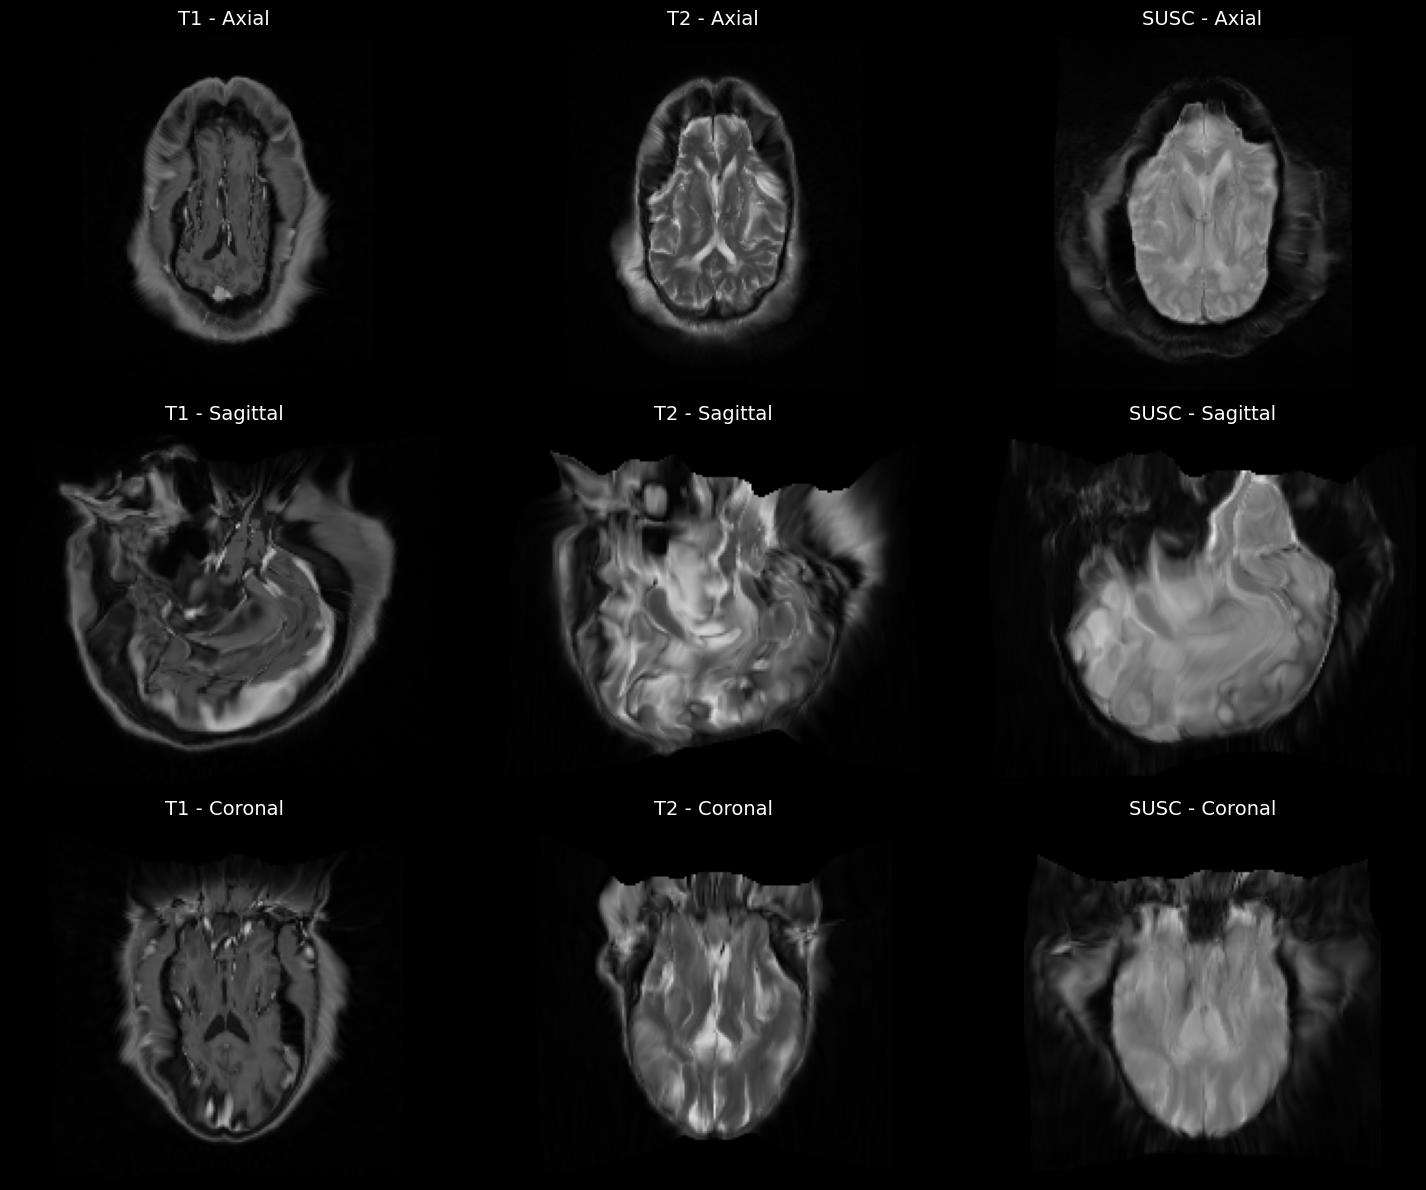


==== Registration Results Summary ====
T1 Registration:
  - Warped image: /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/T1/T1_P1_registered_to_atlas.nii.gz
  - Warped segmentation: /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/T1/T1_P1_seg_registered_to_atlas.nii.gz
  - Warp field: /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/T1/T1_P1_to_atlas_warp.nii.gz
  - Time taken: 21.50 seconds
T2 Registration:
  - Warped image: /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/T2/T2_P1_registered_to_atlas.nii.gz
  - Warped segmentation: /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/T2/T2_P1_seg_registered_to_atlas.nii.gz
  - Warp field: /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/T2/T2_P1_to_atlas_warp.nii.gz
  - Time taken: 20.26 seconds
SUSC Registration:
  - Warped image: /home/mariopasc/Python/Datasets/Meningiomas/output/registration_test/SUSC/SUSC_P1_reg

In [28]:
# Registration test with existing data dictionary

import os
import time
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
import matplotlib.pyplot as plt
import voxelmorph as vxm

# Create a registration test directory
TEST_OUTPUT_DIR = os.path.join(OUTPUT_PATH, "registration_test")
os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)

# Define model path and download if needed
SYNTHMORPH_MODEL_PATH = os.path.join(TEST_OUTPUT_DIR, "shapes-dice-vel-3-res-8-16-32-256f.h5")
if not os.path.exists(SYNTHMORPH_MODEL_PATH):
    print(f"Downloading SynthMorph model to {SYNTHMORPH_MODEL_PATH}")
    !curl -o {SYNTHMORPH_MODEL_PATH} https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5

def normalize_volume(volume):
    """Normalize volume to [0,1] range."""
    volume = volume.astype(np.float32)
    volume -= volume.min()
    volume /= volume.max()
    return volume

def resize_to_model_compatible(img, target_shape=None):
    """Resize image to dimensions compatible with the model (divisible by 16)."""
    if target_shape is None:
        # Make dimensions divisible by 16
        shape = img.GetSize()
        target_shape = [((dim + 15) // 16) * 16 for dim in shape]

    resample = sitk.ResampleImageFilter()
    resample.SetSize(target_shape)
    resample.SetOutputOrigin(img.GetOrigin())
    spacing = [orig_sz * orig_sp / targ_sz for orig_sz, orig_sp, targ_sz in 
              zip(img.GetSize(), img.GetSpacing(), target_shape)]
    resample.SetOutputSpacing(spacing)
    resample.SetOutputDirection(img.GetDirection())
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetDefaultPixelValue(0)
    
    return resample.Execute(img), target_shape

# Load the atlas
print(f"Loading atlas from {ATLAS}")
atlas_img = sitk.ReadImage(ATLAS)

# Common shape for all registrations
common_shape = [160, 192, 160]  # Should be divisible by 16
print(f"Using common registration shape: {common_shape}")

# Resize atlas to common shape
atlas_resampled, _ = resize_to_model_compatible(atlas_img, common_shape)
atlas_array = sitk.GetArrayFromImage(atlas_resampled)
atlas_norm = normalize_volume(atlas_array)[np.newaxis, ..., np.newaxis]

# Initialize the model
print("Initializing registration model...")
model = vxm.networks.VxmDense(
    nb_unet_features=([256] * 4, [256] * 6),
    int_steps=5,
    int_resolution=2,
    svf_resolution=2,
    inshape=common_shape,
)
model = tf.keras.Model(model.inputs, model.references.pos_flow)
model.load_weights(SYNTHMORPH_MODEL_PATH)

# Function to register one modality to atlas
def register_to_atlas(pulse, pulse_data, atlas_norm):
    print(f"\n==== Registering {pulse} to atlas ====")
    start_time = time.time()
    
    # Create pulse output directory
    pulse_output_dir = os.path.join(TEST_OUTPUT_DIR, pulse)
    os.makedirs(pulse_output_dir, exist_ok=True)
    
    # Load the moving image
    moving_img = sitk.ReadImage(pulse_data["output_paths"]["vol"])
    
    # Original shape and spacing
    orig_shape = moving_img.GetSize()
    orig_spacing = moving_img.GetSpacing()
    print(f"Original {pulse} shape: {orig_shape}, spacing: {orig_spacing}")
    
    # Resize to common shape
    moving_resampled, _ = resize_to_model_compatible(moving_img, common_shape)
    moving_array = sitk.GetArrayFromImage(moving_resampled)
    moving_norm = normalize_volume(moving_array)[np.newaxis, ..., np.newaxis]
    
    # First registration pass
    print(f"Running first registration pass...")
    warp_field = model.predict((moving_norm, atlas_norm))
    
    # Apply transformation
    moved = vxm.layers.SpatialTransformer(fill_value=0)((moving_norm, warp_field))
    
    # Second registration pass
    print(f"Running second registration pass...")
    resid = model.predict((moved, atlas_norm))
    combined_warp = vxm.layers.ComposeTransform()((warp_field, resid))
    final_moved = vxm.layers.SpatialTransformer(fill_value=0)((moving_norm, combined_warp))
    
    # Also register the segmentation mask
    seg_img = sitk.ReadImage(pulse_data["output_paths"]["seg"])
    seg_resampled, _ = resize_to_model_compatible(seg_img, common_shape)
    seg_array = sitk.GetArrayFromImage(seg_resampled)
    seg_norm = normalize_volume(seg_array)[np.newaxis, ..., np.newaxis]
    
    # Apply the same transformation to the segmentation with nearest neighbor interpolation
    seg_moved = vxm.layers.SpatialTransformer(
        fill_value=0, 
        interp_method='nearest'
    )((seg_norm, combined_warp))
    
    elapsed = time.time() - start_time
    print(f"Registration completed in {elapsed:.2f} seconds")
    
    # Save the warped volume
    moved_path = os.path.join(pulse_output_dir, f"{pulse}_P{PATIENT}_registered_to_atlas.nii.gz")
    moved_sitk = sitk.GetImageFromArray(np.squeeze(final_moved[0]))
    moved_sitk.SetSpacing(moving_resampled.GetSpacing())
    moved_sitk.SetOrigin(moving_resampled.GetOrigin())
    moved_sitk.SetDirection(moving_resampled.GetDirection())
    sitk.WriteImage(moved_sitk, moved_path)
    
    # Save the segmentation
    seg_moved_path = os.path.join(pulse_output_dir, f"{pulse}_P{PATIENT}_seg_registered_to_atlas.nii.gz")
    seg_moved_sitk = sitk.GetImageFromArray(np.squeeze(seg_moved[0]))
    seg_moved_sitk.SetSpacing(seg_resampled.GetSpacing())
    seg_moved_sitk.SetOrigin(seg_resampled.GetOrigin())
    seg_moved_sitk.SetDirection(seg_resampled.GetDirection())
    sitk.WriteImage(seg_moved_sitk, seg_moved_path)
    
    # Save the warp field
    warp_path = os.path.join(pulse_output_dir, f"{pulse}_P{PATIENT}_to_atlas_warp.nii.gz")
    warp_sitk = sitk.GetImageFromArray(np.squeeze(combined_warp[0]), isVector=True)
    warp_sitk.SetSpacing(moving_resampled.GetSpacing())
    warp_sitk.SetOrigin(moving_resampled.GetOrigin())
    warp_sitk.SetDirection(moving_resampled.GetDirection())
    sitk.WriteImage(warp_sitk, warp_path)
    
    # Update data dictionary with registration paths
    pulse_data["registered_paths"] = {
        "vol": moved_path,
        "seg": seg_moved_path,
        "warp": warp_path
    }
    
    print(f"Results saved to {pulse_output_dir}")
    return {
        "moved_path": moved_path, 
        "seg_path": seg_moved_path,
        "warp_path": warp_path, 
        "elapsed_time": elapsed
    }

# Run registration for all pulses
results = {}
for pulse in PULSES:
    results[pulse] = register_to_atlas(pulse, data[pulse], atlas_norm)

# Create visualization function
def visualize_all_registrations(data_dict, pulses, output_dir):
    """Visualize registration results for all pulses."""
    # Set up figure
    fig, axes = plt.subplots(3, len(pulses), figsize=(5*len(pulses), 12))
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    
    # Set figure background to black
    fig.patch.set_facecolor('black')
    
    # Load all registered images
    images = []
    for pulse in pulses:
        img_path = data_dict[pulse]["registered_paths"]["vol"]
        img = sitk.ReadImage(img_path)
        img_array = sitk.GetArrayFromImage(img)
        images.append(img_array)
    
    # Find global min and max for consistent windowing
    global_min = min(img.min() for img in images)
    global_max = max(img.max() for img in images)
    
    # Get middle slice indices for each view
    i, j, k = (images[0].shape[0] // 2, 
              images[0].shape[1] // 2, 
              images[0].shape[2] // 2)
    
    # Plot each pulse type in columns
    for col, pulse in enumerate(pulses):
        img_array = images[col]
        
        # Axial view (top row)
        ax = axes[0, col]
        ax.imshow(img_array[i, :, :], cmap='gray', vmin=global_min, vmax=global_max)
        ax.set_title(f"{pulse} - Axial", color='white', fontsize=14)
        ax.axis('off')
        
        # Sagittal view (middle row)
        ax = axes[1, col]
        ax.imshow(img_array[:, :, k], cmap='gray', vmin=global_min, vmax=global_max)
        ax.set_title(f"{pulse} - Sagittal", color='white', fontsize=14)
        ax.axis('off')
        
        # Coronal view (bottom row)
        ax = axes[2, col]
        ax.imshow(img_array[:, j, :], cmap='gray', vmin=global_min, vmax=global_max)
        ax.set_title(f"{pulse} - Coronal", color='white', fontsize=14)
        ax.axis('off')
    
    plt.tight_layout()
    
    # Save the visualization
    output_path = os.path.join(output_dir, f"registered_visualization_P{PATIENT}.png")
    plt.savefig(output_path, facecolor='black', bbox_inches='tight', dpi=150)
    print(f"Visualization saved to: {output_path}")
    
    return fig

# Visualize the results
fig = visualize_all_registrations(data, PULSES, TEST_OUTPUT_DIR)
plt.show()

# Print summary of registration results
print("\n==== Registration Results Summary ====")
for pulse, result in results.items():
    print(f"{pulse} Registration:")
    print(f"  - Warped image: {result['moved_path']}")
    print(f"  - Warped segmentation: {result['seg_path']}")
    print(f"  - Warp field: {result['warp_path']}")
    print(f"  - Time taken: {result['elapsed_time']:.2f} seconds")